<a href="https://colab.research.google.com/github/JungMinNoh/19-lab/blob/master/SMARTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.8
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2019.09.1 installation finished!


In [0]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

#SMARTS (SMiles ARbitrary Target Specification)

##SMARTS의 정의
SMiles ARbitrary Target Specification 의 약자로, 앞서 SMILES을 기반으로 하고 추가적인 규칙들로 이루어져 있으며 특정 작용기를 강조하거나, 데이터베이스에서 유사 구조, 특성을 가진 물질을 찾는데 더 유용하다.

##SMILES와의 차이점
SMILES와 SMARTS의 차이점 중 아래 표에 나타낸 것은 더 명확한표현(High Specificity)와 덜 명확한 표현(Low Specificity)를 의미한다.
[CH4] 은 명확하게 수소원자를 4개 가진 탄소원자를 의미하며, SMILES 에서 C와 같다. 그러나 SMARTS에서는 C는 단순히 탄소원자, 즉 수소원자가 얼마나 결합하고 있는지는 포함하지 않는다. 

| SMILE | | SMARTS ||
|:----------|:----------:|----------:|----------:|
| [CH4]  | methane | [CH4] |methane|
| C | methane | C |`carbon atoms` with any number of hydrogens|


이를 RDkit의 함수를 이용하여 확인하면 아래와 같다.  
‘확인할 화합물’.GetSubstructMatch(‘비교대상’)
확인할 화합물에 비교대상이 포함 된다면 일치하는 순서의 위치를 결과값으로 보여준다. 만약 중복되는 위치가 있다면 순서가 앞쪽인 원자만 확인한다. 포함이 되지 않는다면 ()을 출력한다.
을 의미하는 'CC'를 확인하면 [CH4]으로는 포함되는 부분이 없지만, C로 확인한 경우는 수소원자의 개수에 상관없이 C를 포함한다고 인식한다.

In [4]:
AllChem.MolFromSmiles('CC').GetSubstructMatch(AllChem.MolFromSmarts('[CH4]'))

()

In [5]:
AllChem.MolFromSmiles('CC').GetSubstructMatch(AllChem.MolFromSmarts('C'))

(0,)

##SMARTS의 규칙

| 표현 | 표현이름 | 의미 |기본값|
|:----------|:----------:|----------:|----------:|
| *  | wildcard (무작위) | any atom |-|
| a  | aromatic | aromatic |-|
| A  | aliphatic | aliphatic |-|
| D< n>  | degree | < n>explicit connections |1|
| H< n>  | total-H-count | < n>attached hydrogens |1|
| h< n>  |implicit-H-count | < n> implicit hydrogens |최소1|
| R< n>  | ring membership |in < n>SSSR rings |-|
| r< n>  | ring size | in smallest SSSR ring of size < n> |-|
| v< n>  | valence | total bond order < n> |1|
| X< n>  | connectivity | < n> total connections |1|
| x< n>  | ring connectivity | < n> total ring connections |최소1|
| -< n>  | negative charge	 | - < n> charge |-1|
| +< n>  | positive charge | + < n> formal charge |+1|
| #n  | atomic number | atomic number < n> |-|
| @  | chirality	 | anticlockwise |반시계|
| @@  | chirality	 | clockwise |시계방향|
| < n> | atomic mass | explicit atomic mass |-|


In [0]:
ex1 = AllChem.MolFromSmarts('[#6]')

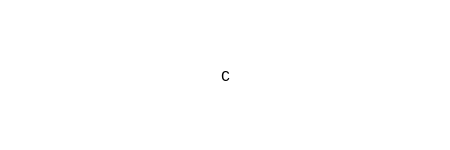

In [7]:
ex1

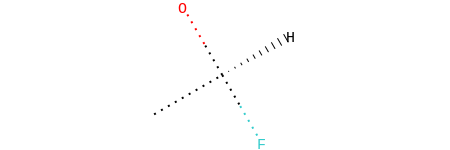

In [8]:
ex1 = AllChem.MolFromSmarts('C[C@H](F)O')
ex1

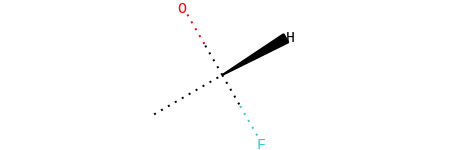

In [9]:
ex2 = Chem.MolFromSmarts('C[C@@H](F)O')
ex2

## Bond Primitives (결합 표현)
결합에 대한 표현들은 아래와 같다. 결합을 표시하지 않으면 단일결합 또는 방향족 결합으로 인식한다.

| 표현 | 표현이름 | 
|:----------|:----------:|
| - | 단일결합 | 
| / | 위쪽 방향으로 결합 | 
| \ | 아래쪽 방향으로 결합 | 
| /? | 위쪽 방향 또는 모르는 결합 | 
| \? | 아래쪽 방향 또는 모르는 결합 | 
| = | 이중결합 | 
| # | 삼중결합 | 
| : | 방향족 결합 | 
| ~ | Wild Card (결합 중 어떤것 하나) | 
| @ | 고리결합 | 



아래의 예시를 통해 확인할 수 있다.

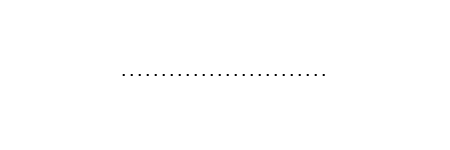

In [11]:
m1 = AllChem.MolFromSmarts('CC')
m1

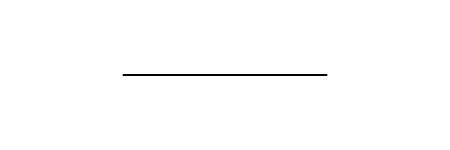

In [14]:
mol = AllChem.MolFromSmarts('C-C') #단일결합의 결과
mol

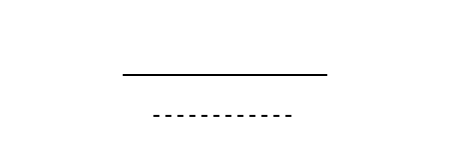

In [15]:
mol = AllChem.MolFromSmarts('c:c') #방향족 결합의 결과
mol

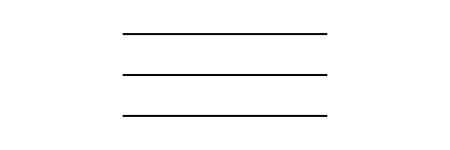

In [18]:
mol = AllChem.MolFromSmarts('c#c') #삼중 결합의 결과
mol

## Logical Operators (논리적 연산자)
원자, 결합에 대한 정보를 의미하는 규칙 이외에도 집합에서 교집합, 여집합과 같은 논리적인 의미를 가진 표현이 있다.

| 기호 | 표현 | 의미|  
|:----------|:----------:|:----------:|
| 느낌표 (!) | !e1 | e1 을 제외| 
| Ampersand (&) | e1&e2 | e1 그리고 e2| 
| 반점 (,) | e1,e2 | e1 또는 e2 | 
| 쌍반점(semicolon, ;) | e1;e2 | e1 그리고 e2 | 



## Recursive SMARTS (반복되는 표현의 줄임)


In [0]:
#‘$’를 이용하여 둘 이상의 중복되는 표현이 있을때, 중복되는 부분을 하나로 줄이면서 ‘$’를 이용한다.

## Reaction Queires(반응식 표현)

앞서 SMILES에서와 마찬가지로 반응식은 반응물, 중간체, 생성물로 구성되어있고 그 사이를 ‘>’로 구분한다. 또한 Atom Map도 동일하게 적용된다.

#활용

SMILES와 SMARTS를 통해 다양하게 활용할 수 있다. 데이터 베이스에서 특정 성질, 구조를 가진 분자들을 찾거나 반응식을 적용시켜 생성물을 결과로써 확인할 수 있다.

같은 구조를 가졌는지 확인할 수 있는 예시

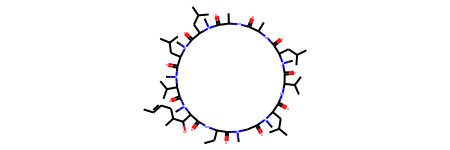

In [27]:
m = Chem.MolFromSmiles('C/C=C/CC(C)C(O)C1C(=O)NC(CC)C(=O)N(C)CC(=O)N(C)C(CC(C)C)C(=O)NC(C(C)C)C(=O)N(C)C(CC(C)C)C(=O)NC(C)C(=O)NC(C)C(=O)N(C)C(CC(C)C)C(=O)N(C)C(CC(C)C)C(=O)N(C)C(C(C)C)C(=O)N1C') #m 결과
m

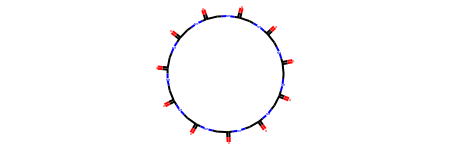

In [26]:
core =Chem.MolFromSmiles('C1C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)N1') #core 결과
core

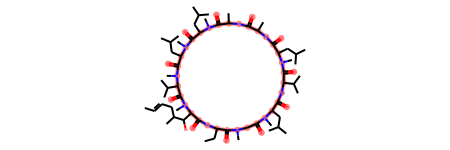

In [25]:
m.GetSubstructMatch(core) #m과 core의 합
m

m에 저장되어있는 화합물에 뼈대를 이루고 있는 core를 표현할 수 있다.

## 특성 확인하기

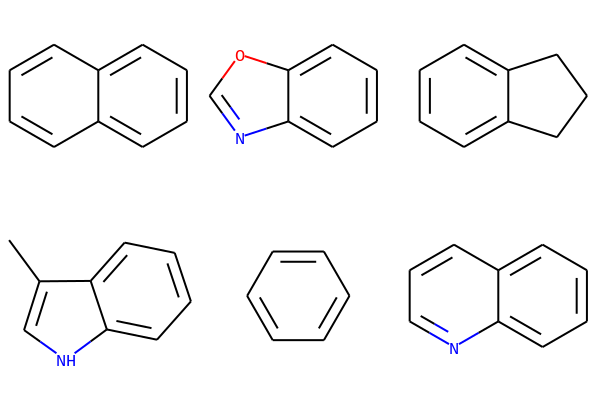

In [29]:
naphthalene = Chem.MolFromSmiles('c12ccccc1cccc2')
benzoxazole = Chem.MolFromSmiles('n1c2ccccc2oc1')
indane = Chem.MolFromSmiles('c1ccc2c(c1)CCC2')
skatole = Chem.MolFromSmiles('CC1=CNC2=CC=CC=C12')
benzene = Chem.MolFromSmiles('c1ccccc1')
quinoline = Chem.MolFromSmiles('n1cccc2ccccc12')
my_molecules = [naphthalene, 
                benzoxazole,
                indane,
                skatole,
                benzene,
                quinoline, ]
Draw.MolsToGridImage(my_molecules, useSVG=False)

In [33]:
is_in_two_rings = Chem.MolFromSmarts('[R2]') # '[R2]'를 이용해 고리를 2개 가진 분자들에만 True로써 반환한다.
[mol.HasSubstructMatch(is_in_two_rings) for mol in my_molecules] 

[True, True, True, True, False, True]

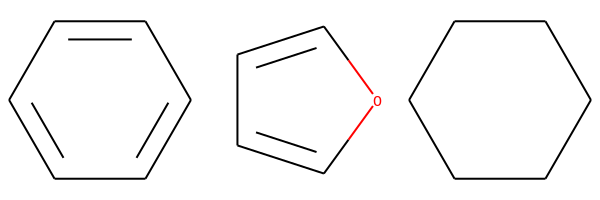

In [35]:
mol1 = Chem.MolFromSmiles('c1ccccc1')
mol2 = Chem.MolFromSmiles('o1cccc1')
mol3 = Chem.MolFromSmiles('C1CCCCC1')
my_mol = [mol1,mol2,mol3] #방향족 & 지방족 분자 집합
Draw.MolsToGridImage(my_mol, useSVG=False)

In [36]:
aromatic = Chem.MolFromSmarts('c') #방향족 탄소원자 'c'를 가졌는지 확인한다.
[mol.HasSubstructMatch(aromatic) for mol in my_mol]

[True, True, False]

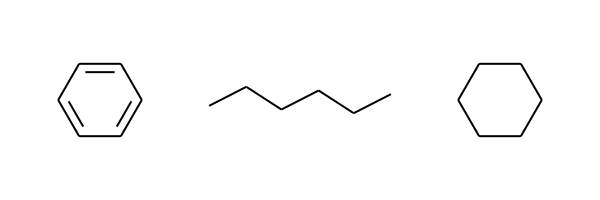

In [38]:
mol1 = Chem.MolFromSmiles('c1ccccc1')
mol2 = Chem.MolFromSmiles('CCCCCC')
mol3 = Chem.MolFromSmiles('C1CCCCC1')
my_mol = [mol1,mol2,mol3] #분자 집합
Draw.MolsToGridImage(my_mol, useSVG=False)

In [39]:
noaromatic = Chem.MolFromSmarts('[!c]')
[mol.HasSubstructMatch(noaromatic) for mol in my_mol]

[False, True, True]

In [41]:
no1 = Chem.MolFromSmarts('[R]')
[mol.HasSubstructMatch(no1) for mol in my_mol]

[True, False, True]

In [42]:
no2 = Chem.MolFromSmarts('[!c&R]')
[mol.HasSubstructMatch(no2) for mol in my_mol]

[False, False, True]

In [43]:
no3 = Chem.MolFromSmarts('[!c,R]')
[mol.HasSubstructMatch(no3) for mol in my_mol]

[True, True, True]

또한 논리적 연산자들을 이용해 둘 이상의 조건을 확인할 수 있다.

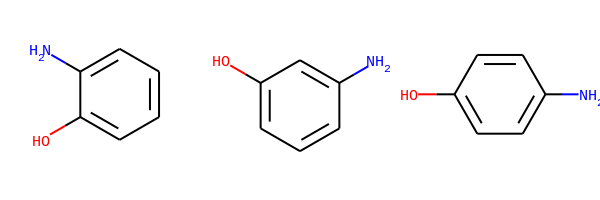

In [46]:
mol1 = Chem.MolFromSmiles('c1c(O)c(N)ccc1')
mol2 = Chem.MolFromSmiles('c1c(O)cc(N)cc1')
mol3 = Chem.MolFromSmiles('c1c(O)ccc(N)c1')
my_mol = [mol1,mol2,mol3] #분자집합
Draw.MolsToGridImage(my_mol, useSVG=False)

In [47]:
no6 = Chem.MolFromSmarts('[#6]aaO') 
[mol.HasSubstructMatch(no6) for mol in my_mol]

[True, True, True]

In [48]:
no7 = Chem.MolFromSmarts('[#6]aaaN')
[mol.HasSubstructMatch(no7) for mol in my_mol]

[True, True, True]

In [49]:
no8 = Chem.MolFromSmarts('[#6]aa(O)aN')
[mol.HasSubstructMatch(no8) for mol in my_mol]

[True, False, False]

In [50]:
no9 = Chem.MolFromSmarts('[#6][$(aaO);$(aaaN)]')
[mol.HasSubstructMatch(no9) for mol in my_mol]

[True, False, True]

또한 ‘$’ 를 이용해 중복되는 것을 생략할 수 있으며, 위에서 ';'를 이용해 ‘그리고’를 의미하는 논리적 연산자를 이용해 no8과 no9의 결과값이 다른것을 확인할 수 있다.

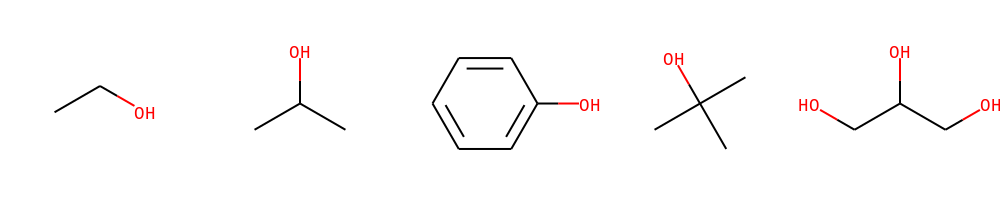

In [51]:
ethanol = Chem.MolFromSmiles('CCO')
isopropanol = Chem.MolFromSmiles('CC(C)O')
phenol = Chem.MolFromSmiles('c1cccc(O)c1')
t_butanol = Chem.MolFromSmiles('C(C)(C)(C)O')
glycerol = Chem.MolFromSmiles('OCC(O)CO')

alcohols = [ethanol, isopropanol, phenol, t_butanol, glycerol]
Draw.MolsToGridImage(alcohols, molsPerRow=5)

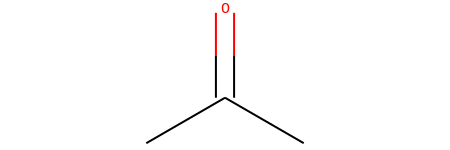

In [56]:
rxn_1 = AllChem.ReactionFromSmarts('[#6:1]([O:2])>>[#6:1](=[O:2])') #탄소와 산소의 단일결합에서 이중결합을 하도록 반응식을 설정해준다.
rxn_1.RunReactants((isopropanol, ))[0][0] #이를 확인하면, 처음 집합의 두번째 순서였던 Isopropanol의 반응 결과이다.